In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial import KDTree
import geopandas as gpd
import rtree
import seaborn as sns
import os
import concurrent.futures
import gzip
from tqdm import tqdm
from shapely.geometry import box
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

In [13]:
# load data
# adata = sc.read_h5ad('/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/pipelines/xenium/local/cellcharter_nhoods/linearAmp_ecEGFR_harmony.h5ad')
adata = sc.read_h5ad('/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig6/Fig6.1/data/wt_adata_p52P_filtered.h5ad')
samples_matching_dict = adata.obs[['sample', 'sample_2']].drop_duplicates('sample').set_index('sample_2').to_dict()['sample']
proseg_dir = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/data/processed/xenium/expan5um/proseg'
celltype_matching_dict = adata.obs['cell_type_final'].to_dict()
linearAmp_samples = ['p19P', 'p51P', 'p52P','p67P']
ecEGFR_samples = ['p15P', 'p29P', 'p46P','p55P', 'p59P']

subset_adata = adata[adata.obs['sample_2'].isin(linearAmp_samples+ecEGFR_samples)]
subset_adata.obs['subtype'] = np.where(subset_adata.obs['sample_2'].isin(linearAmp_samples), 'linearAmp', 'ecDNA')
subset_adata.obsm['spatial'] = subset_adata.obs[['centroid_x','centroid_y']].values

/var/folders/xc/nsnyygq95xq2nw5mj137xz040000gq/T/ipykernel_32992/503080212.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset_adata.obs['subtype'] = np.where(subset_adata.obs['sample_2'].isin(linearAmp_samples), 'linearAmp', 'ecDNA')


In [15]:
plot_dir = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig6/Fig6.1/plots'

In [16]:
class AnalyzeNeighbors():

    def __init__(self, 
                 sample_adata, 
                 cell_type,
                 proseg_dir='/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/data/processed/xenium/expan5um/proseg',
                 immediate_neighbors=True,
                 split_by_celltype=None
                 ):
        self.adata = sample_adata
        self.proseg_dir = proseg_dir
        self.sample = sample_adata.obs['sample_2'].unique()[0]
        self.cell_type = cell_type
        self.split_by_celltype = split_by_celltype

        if immediate_neighbors:
            self.neighbors = self.find_immediate_neighbors(self.prepare_gdf())
        else:
            self.neighbors = self.find_nearest_neighbors(self.prepare_gdf())
        neighbors_df = pd.DataFrame.from_dict(self.neighbors, orient='index')
        neighbors_df.dropna(how='all', inplace=True)
        neighbors_df.dropna(axis=1, how='all', inplace=True)
        neighbors_df['cell_type'] = neighbors_df.index.map(self.adata.obs['cell_type_final'])
        self.celltype_neighbors_df = neighbors_df[neighbors_df['cell_type']==cell_type].drop(columns='cell_type')

    def prepare_gdf(self):
        with gzip.open(f'{self.proseg_dir}/{self.adata.obs["sample"].unique()[0]}/cell-polygons.geojson.gz', 'rb') as f:
            gdf = gpd.read_file(f)
        gdf['cell'] = gdf['cell'].astype('str')
        gdf['cell_id'] = [self.sample+'_'+x for x in gdf['cell']]
        gdf = gdf.merge(self.adata.obs.reset_index(), on='cell_id', how='inner')
        gdf.set_index('cell_id', inplace=True)
        return gdf

    def find_immediate_neighbors(self, gdf, tolerance=0, min_cells=1):
        # Build an R-tree spatial index for fast lookup
        spatial_index = rtree.index.Index()
        # Insert each polygon's bounding box into the spatial index
        for i, geom in enumerate(gdf.geometry):
            spatial_index.insert(i, geom.bounds)
        # find immediate neighbors
        neighbors_indices = {}
        for i, geom in enumerate(gdf.geometry):
            geom = geom.buffer(tolerance) if tolerance > 0 else geom
            # Get possible neighbors using bounding box lookup
            possible_neighbors = list(spatial_index.intersection(geom.bounds))
            # adjacent cells or overlapping cells
            ## cell_id as the index
            true_neighbors = [gdf.index[j] for j in possible_neighbors if i != j and (geom.touches(gdf.geometry.iloc[j]) or geom.intersects(gdf.geometry.iloc[j]))] 
            if len(true_neighbors) > min_cells:
                neighbors_indices[gdf.index[i]] = true_neighbors
            else:
                neighbors_indices[gdf.index[i]] = []
        return neighbors_indices 

    def find_nearest_neighbors(self, gdf, k=8):
        # Extract centroids of geometries for KDTree
        centroids = self.adata.obs[['centroid_x', 'centroid_y']].values
        # Build KDTree from centroids
        tree = KDTree(centroids)
        # Find k+1 nearest neighbors (including self)
        distances, indices = tree.query(centroids, k=k+1)
        # Create a dictionary of neighbors (skip the first one as it's the point itself)
        neighbors_dict = {}
        for i, idx_array in enumerate(indices):
            # Convert from position indices to original dataframe indices
            neighbors = [gdf.index[j] for j in idx_array[1:]]  # Skip first (self)
            neighbors_dict[gdf.index[i]] = neighbors
        return neighbors_dict
    
    def get_neighbor_cell_counts(self, nhood_df=None):
        """
        Count the number of each cell type in the neighborhood.
        """
        if nhood_df is None:
            nhood_df = self.celltype_neighbors_df
            
        # Get unique cell types from the AnnData object
        cell_types = self.adata.obs['cell_type_final'].unique().tolist()
        
        # Create an empty DataFrame with columns for each cell type
        cell_counts = pd.DataFrame(0, index=nhood_df.index, columns=cell_types)
        
        # Map cell IDs to cell types and count them
        for idx, row in nhood_df.iterrows():
            for col in row.index:
                neighbor_id = row[col]
                if pd.notna(neighbor_id):
                    cell_type = self.adata.obs.loc[neighbor_id, 'cell_type_final'] if neighbor_id in self.adata.obs.index else None
                    if cell_type and cell_type in cell_counts.columns:
                        cell_counts.loc[idx, cell_type] += 1
        return cell_counts
    
    def get_neighbor_cell_type_ratio(self, counts_df):
        counts = counts_df.sum(axis=0)
        ratios = counts / counts.sum()
        return ratios.to_frame('count')
    
    def get_neighbor_results(self, counts_df=None):
        if counts_df is None:
            counts_df = self.get_neighbor_cell_counts()
            
        if self.split_by_celltype is not None:
            # Split cells based on whether they have neighbors of the specified cell type
            tmp_df = counts_df.copy()
            group1 = f'with_{self.split_by_celltype}_neighbor'
            group2 = f'without_{self.split_by_celltype}_neighbor'
            tmp_df['group'] = np.where(tmp_df[self.split_by_celltype] > 0, group1, group2)
            
            # Calculate mean counts for each group
            counts_mean = tmp_df.groupby('group').mean().T
            
            # Calculate ratios for each group
            ratio1 = self.get_neighbor_cell_type_ratio(tmp_df[tmp_df['group'] == group1].drop(columns='group'))
            ratio1.columns = [group1]
            ratio2 = self.get_neighbor_cell_type_ratio(tmp_df[tmp_df['group'] == group2].drop(columns='group'))
            ratio2.columns = [group2]
            ratio = pd.merge(ratio1, ratio2, left_index=True, right_index=True)
        else:
            # If not splitting, calculate overall ratios
            ratio = self.get_neighbor_cell_type_ratio(counts_df)
            counts_mean = counts_df.mean().to_frame('mean')
            
        ratio['sample'] = self.sample
        return counts_df, counts_mean, ratio

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 47 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:4.394e-288 U_stat=1.317e+07


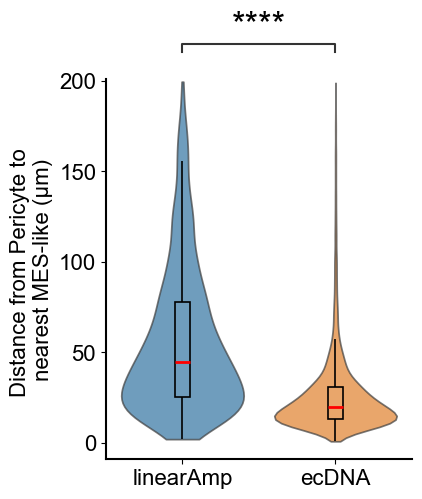

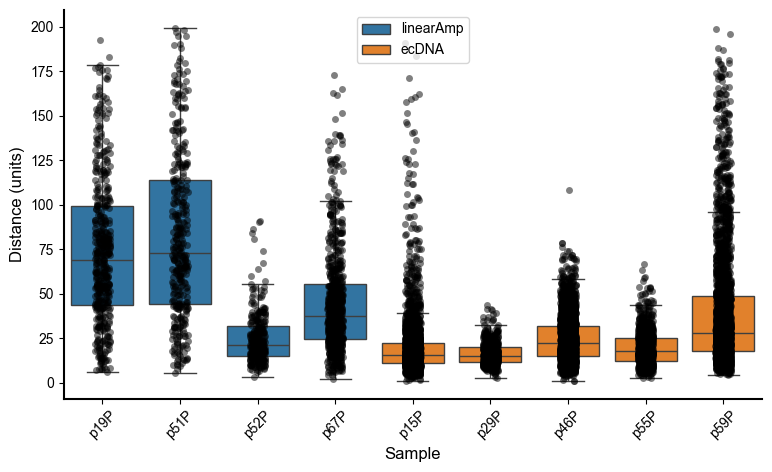

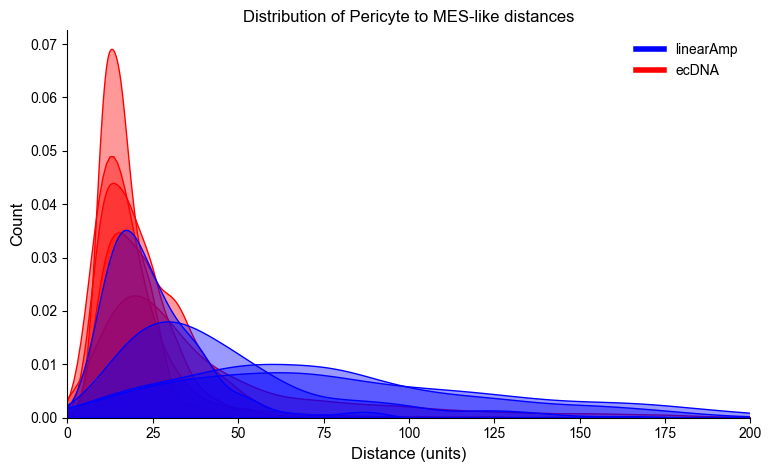

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 18 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.502e-01 U_stat=8.954e+06


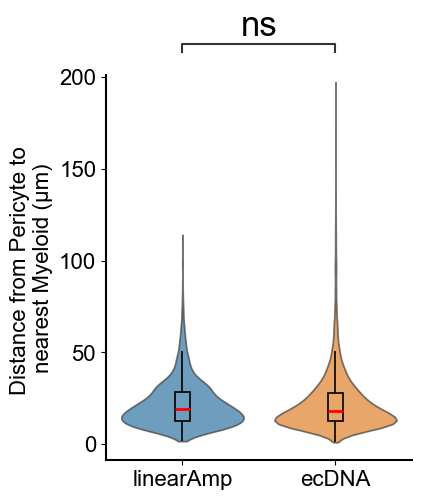

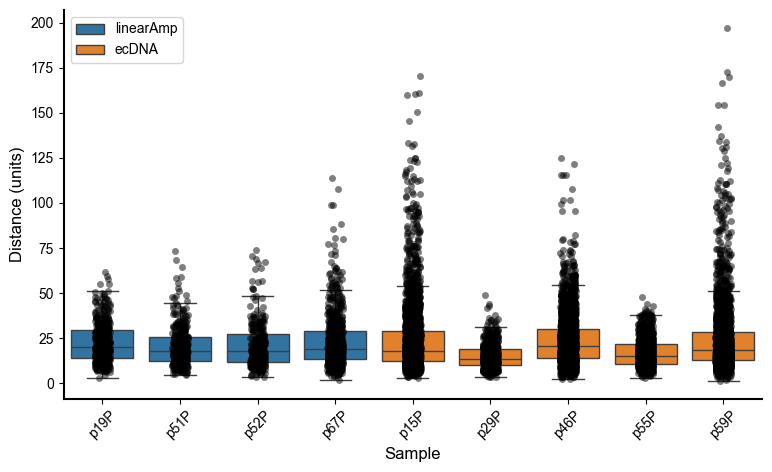

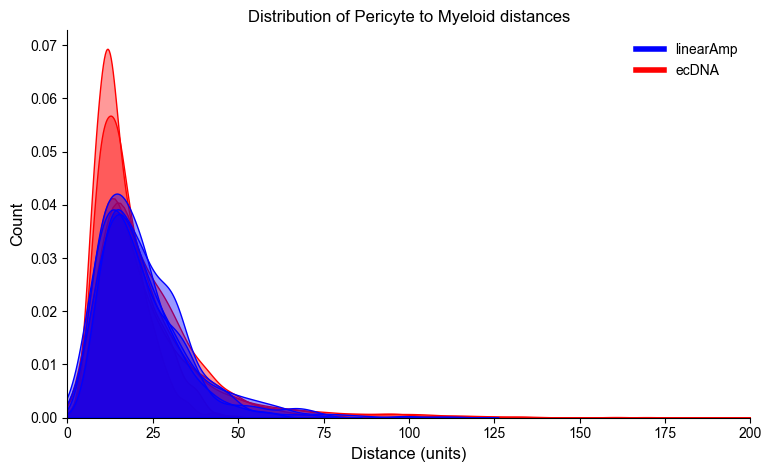

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 3167 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:7.129e-54 U_stat=4.992e+06


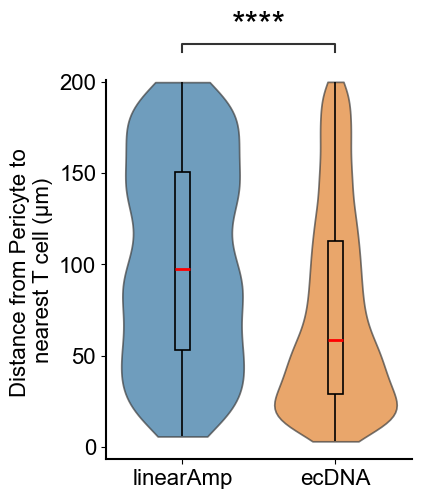

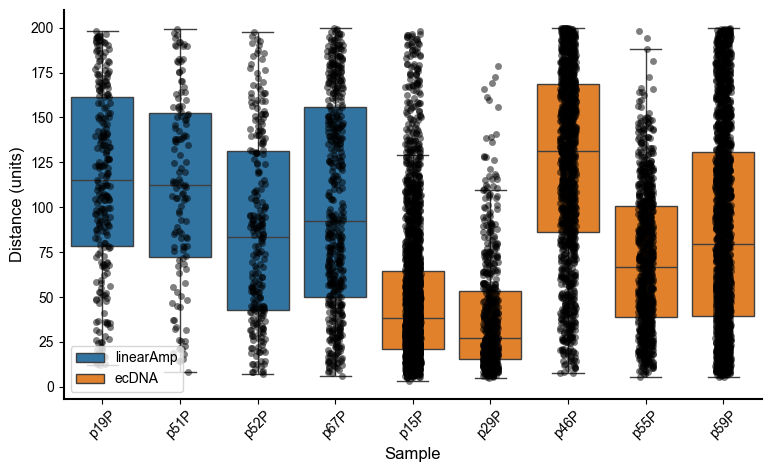

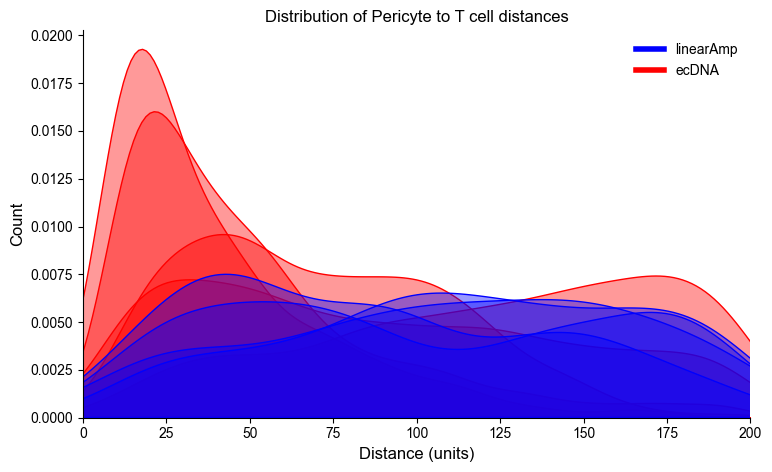

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 1792 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.280e-123 U_stat=4.607e+06


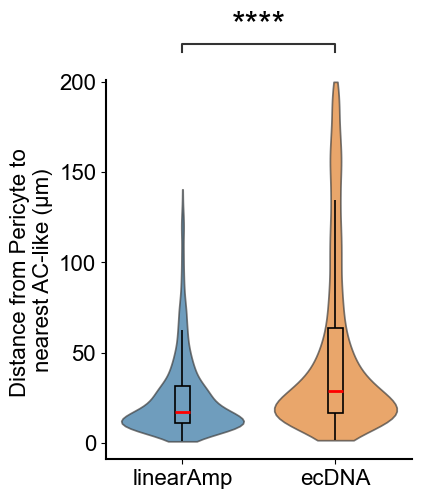

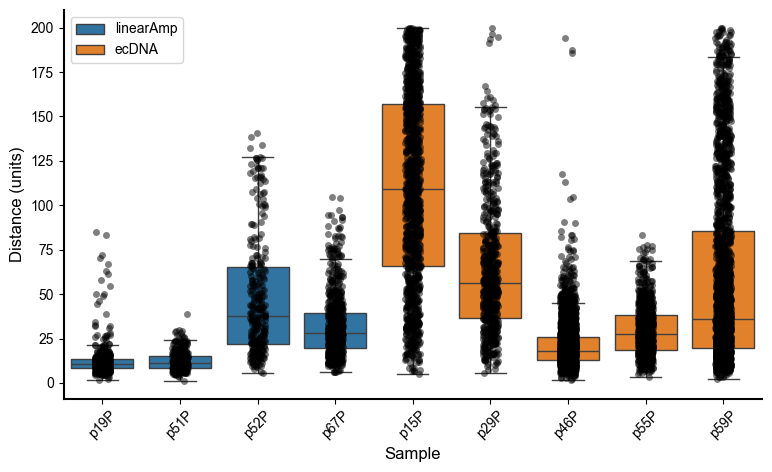

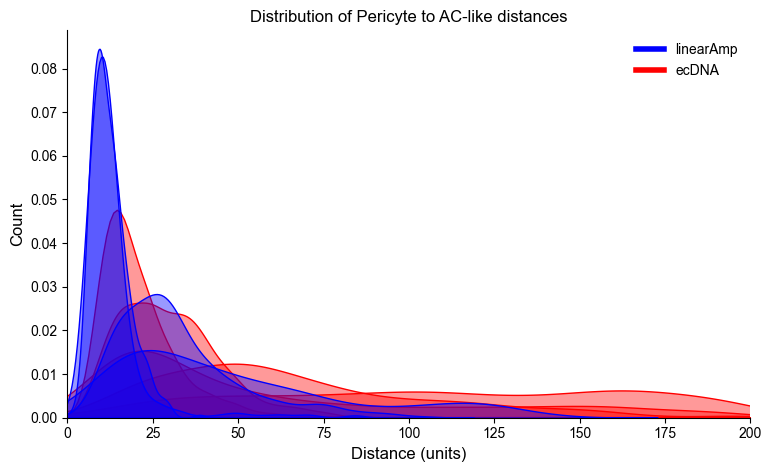

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 357 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.580e-132 U_stat=5.380e+06


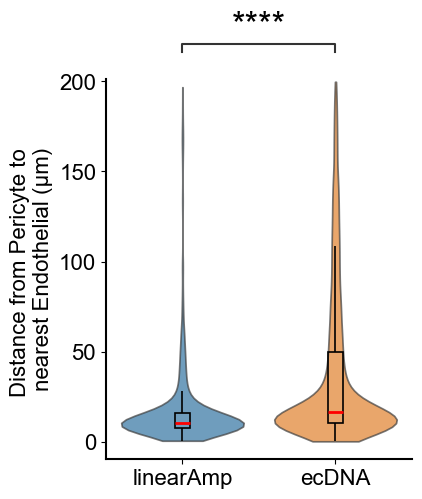

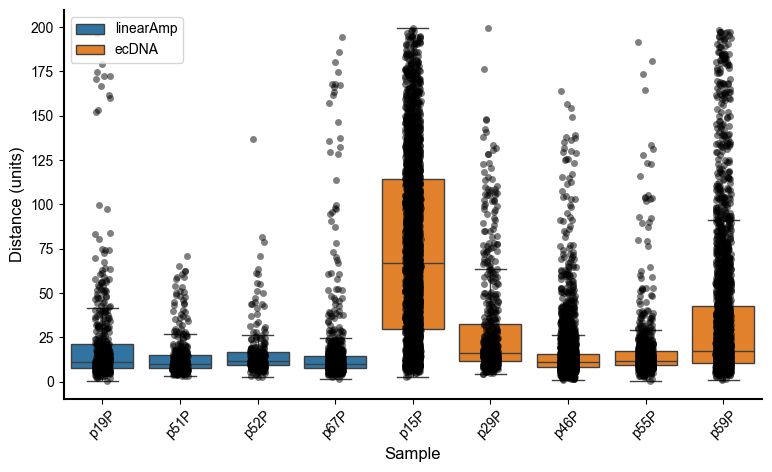

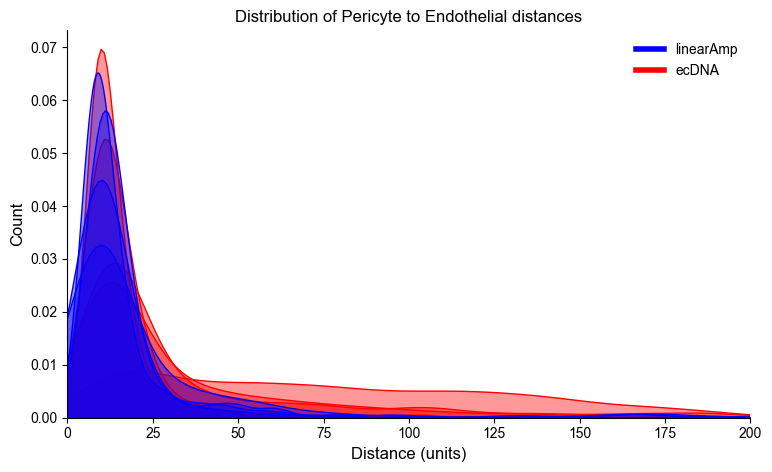

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 3275 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:3.761e-142 U_stat=3.507e+06


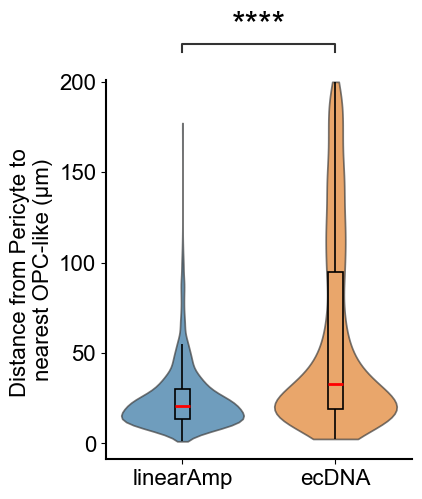

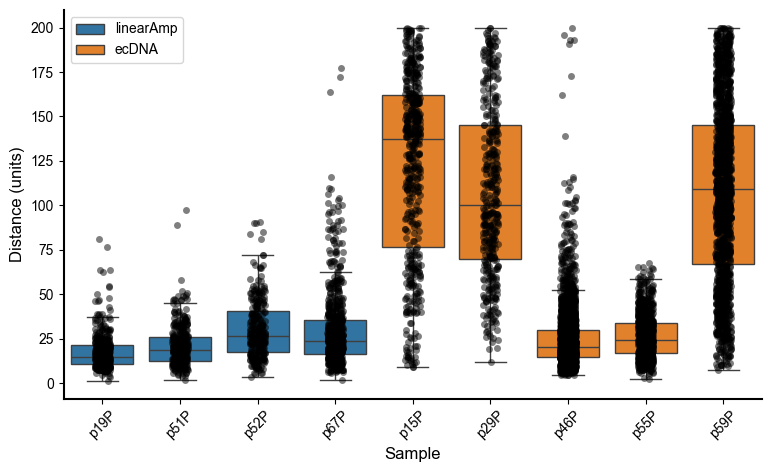

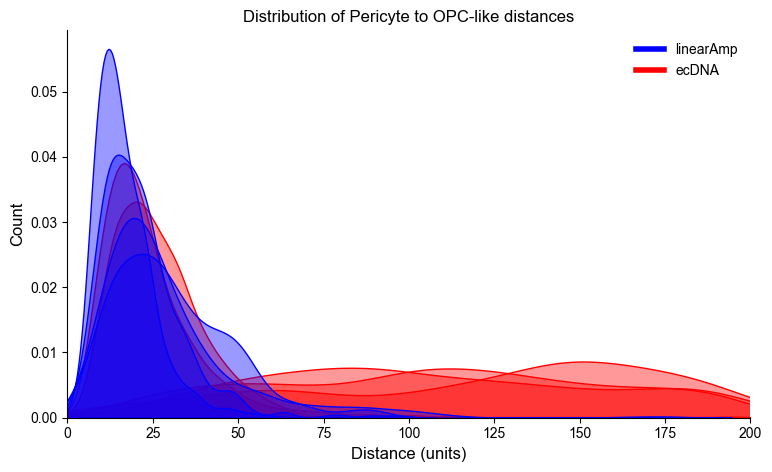

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 1271 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.878e-07 U_stat=7.800e+06


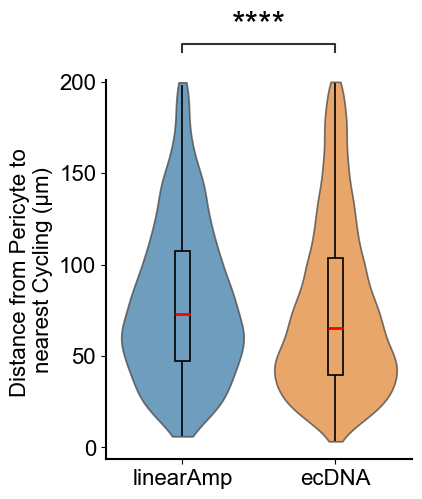

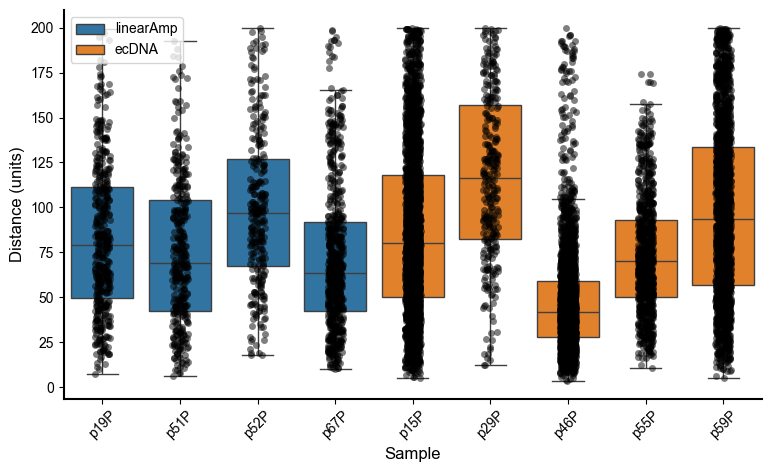

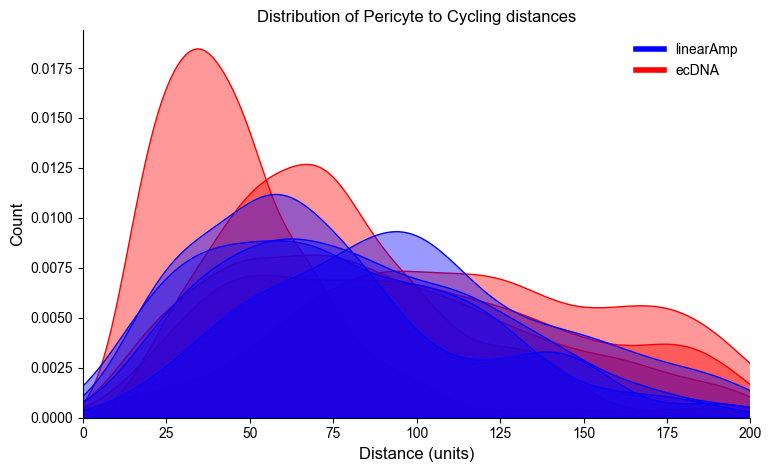

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
No Pericyte or Excitatory neuron cells found in sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 7386 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.171e-18 U_stat=7.232e+05


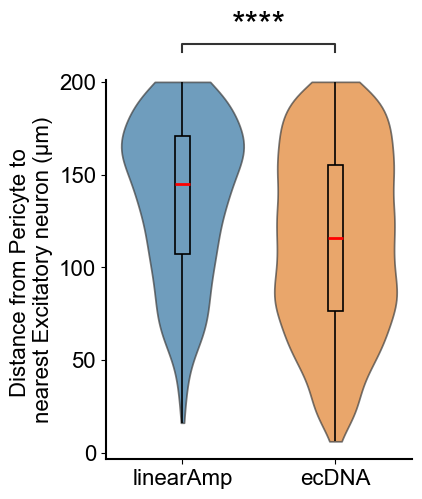

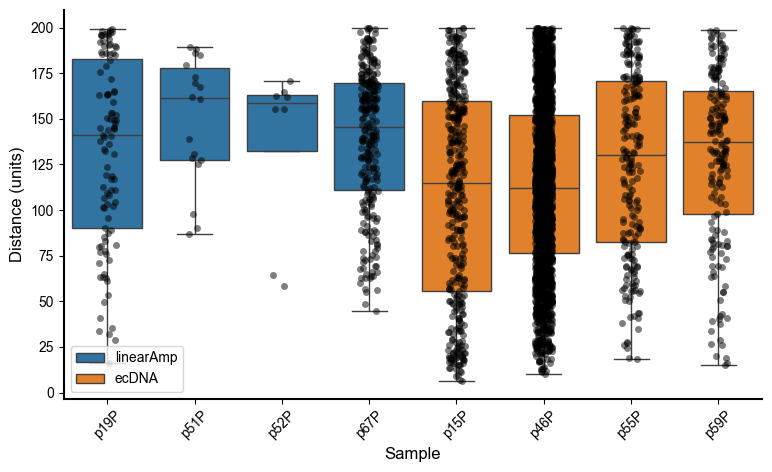

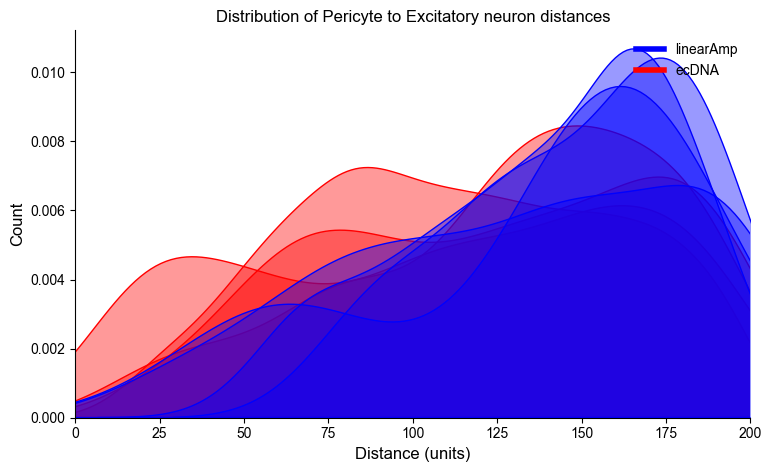

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
No Pericyte or Inhibitory neuron cells found in sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 7768 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:5.290e-02 U_stat=3.403e+05


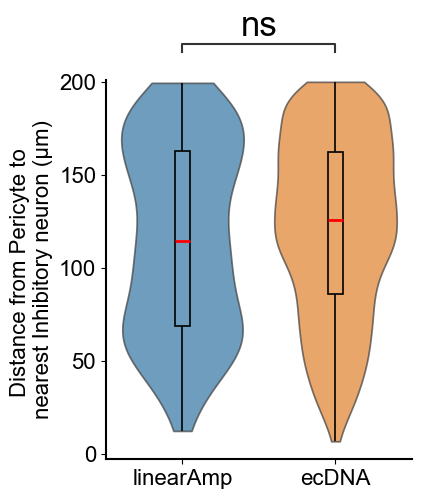

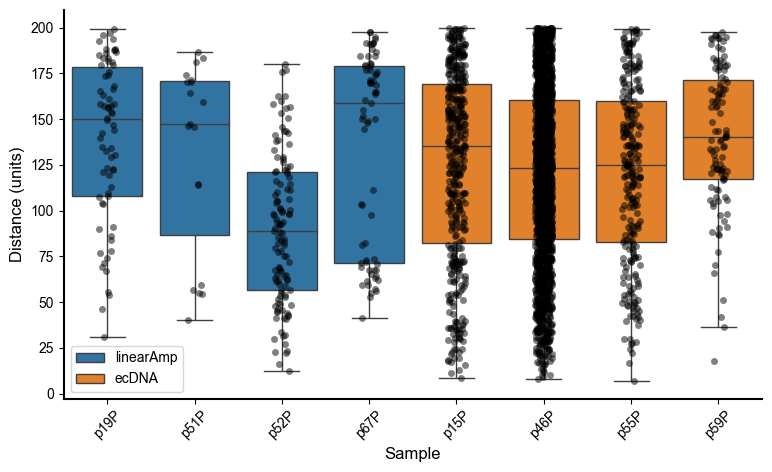

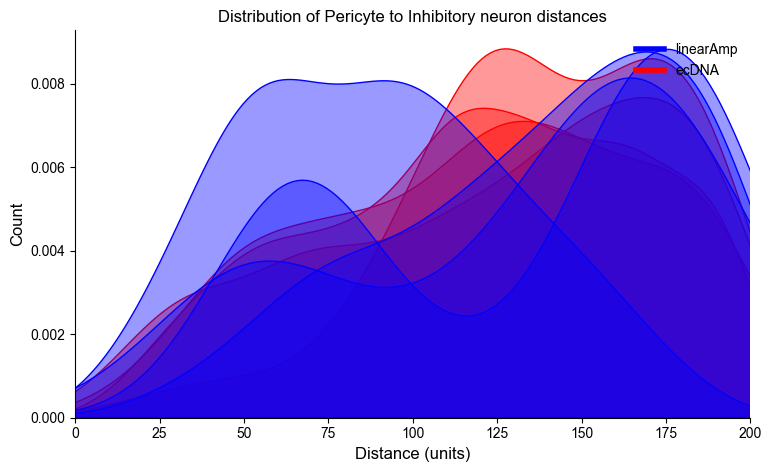

Processing sample p19P
Processing sample p51P
Processing sample p52P
Processing sample p67P
Processing sample p15P
Processing sample p29P
No Pericyte or Oligodendrocyte cells found in sample p29P
Processing sample p46P
Processing sample p55P
Processing sample p59P
Removed 6466 cells with distances > 200
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linearAmp vs. ecDNA: Mann-Whitney-Wilcoxon test two-sided, P_val:5.886e-234 U_stat=9.079e+05


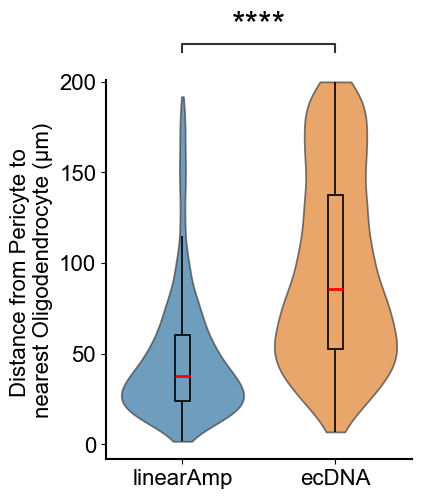

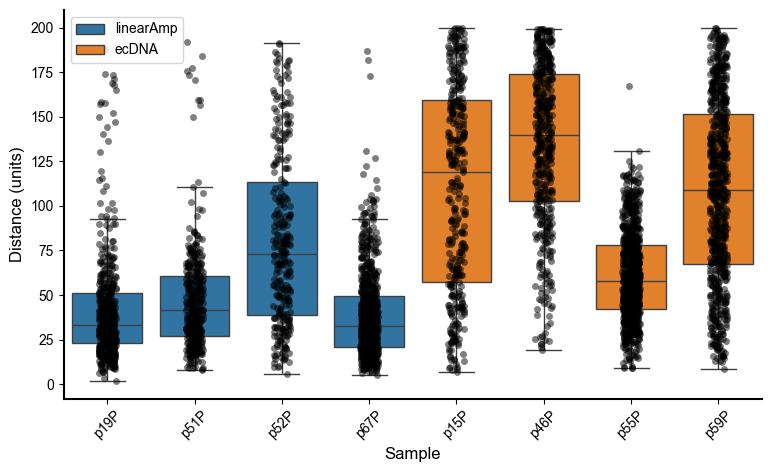

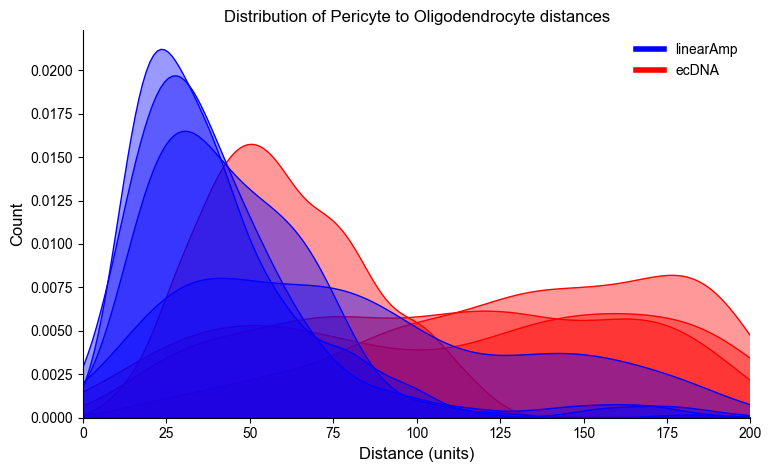

In [35]:
from scipy.spatial import KDTree
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu

## distance
import matplotlib.pyplot as plt
def get_nearest_distance_by_cell_type(adata, source_cell_type, target_cell_type):
    """
    Calculate the distance between cells of source_cell_type and their nearest target_cell_type neighbor.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object containing spatial coordinates
    source_cell_type : str
        Cell type for which to find nearest neighbors
    target_cell_type : str
        Cell type to find as nearest neighbors
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the distances for each source cell
    """
    results = []
    
    for ss in linearAmp_samples + ecEGFR_samples:
        print(f"Processing sample {ss}")
        sample_adata = adata[adata.obs['sample_2'] == ss].copy()
        
        # Get coordinates of source and target cells
        source_cells = sample_adata[sample_adata.obs['cell_type_final'] == source_cell_type] # pericyte
        target_cells = sample_adata[sample_adata.obs['cell_type_final'] == target_cell_type]
        
        if len(source_cells) == 0 or len(target_cells) == 0:
            print(f"No {source_cell_type} or {target_cell_type} cells found in sample {ss}")
            continue
        
        # Extract coordinates
        source_coords = source_cells.obs[['centroid_x', 'centroid_y']].values
        target_coords = target_cells.obs[['centroid_x', 'centroid_y']].values
        
        # Build KDTree for efficient nearest neighbor search
        tree = KDTree(target_coords)
        
        # Find nearest target cell for each source cell
        distances, _ = tree.query(source_coords, k=1)
        
        # Create result dataframe
        cell_df = pd.DataFrame({
            'cell_id': source_cells.obs.index,
            'distance': distances,
            'sample': ss,
            'group': 'linearAmp' if ss in linearAmp_samples else 'ecDNA'
        })
        
        results.append(cell_df)
    
    if not results:
        return pd.DataFrame()
    
    return pd.concat(results, ignore_index=True)

def analyze_pericyte_distances(adata, source_celltype='Pericyte', neighbor_celltype='MES-like', distance_threshold=200):
    # Calculate distances from Pericytes to nearest MES-like cells
    pericyte_to_mes_distances = get_nearest_distance_by_cell_type(adata, source_celltype, neighbor_celltype)

    # Filter out distances > 200
    filtered_distances = pericyte_to_mes_distances[pericyte_to_mes_distances['distance'] <= distance_threshold]
    print(f"Removed {len(pericyte_to_mes_distances) - len(filtered_distances)} cells with distances > {distance_threshold}")

    # Plot the filtered distances
    fig, ax = plt.subplots(figsize=(4.5,5.3))
    sns.violinplot(data=filtered_distances, x='group', y='distance',hue='group', palette='tab10', inner=None, alpha=0.7,ax=ax, cut=0)
    # sns.stripplot(data=filtered_distances, x='group', y='distance', color='black', alpha=0.5, jitter=True, size=2)
    
    sns.boxplot(data=filtered_distances, x='group', y='distance',hue='group',
            width=0.1, showcaps=False, showfliers=False,
            boxprops={'facecolor': 'none', 'edgecolor': 'black', 'linewidth': 1.2},
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            medianprops={'color': 'red', 'linewidth': 2},
            saturation=0.5, ax=ax,
            # positions=[x_pos[i] + offsets[i]]
            )
    box_pairs = [('linearAmp', 'ecDNA')]
    annotator = Annotator(ax, box_pairs, data=filtered_distances, x='group', y='distance')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2, fontsize=25)
    annotator.apply_and_annotate()

    # Set spine line width to 1.5
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    # Add statistical test
    # linearAmp_distances = filtered_distances[filtered_distances['group'] == 'linearAmp']['distance']
    # ecEGFR_distances = filtered_distances[filtered_distances['group'] == 'ecEGFR']['distance']
    # stat, p_value = mannwhitneyu(linearAmp_distances, ecEGFR_distances)
    # plt.gca().spines['top'].set_linewidth(1.5)
    # plt.gca().spines['right'].set_linewidth(1.5)
    # plt.gca().spines['left'].set_linewidth(1.5)
    # plt.gca().spines['bottom'].set_linewidth(1.5)

    # plt.title(f'Distance from {source_celltype} to nearest {neighbor_celltype} cells\nMann-Whitney U p={p_value:.4f}')
    ax.set_ylabel(f'Distance from Pericyte to \nnearest {neighbor_celltype} (µm)')
    # plt.xticks(rotation=45, ha='right')
    ax.set_xlabel('')
    ymin, _ = ax.get_ylim()
    ax.set_ylim(ymin, 201)

    sns.despine()
    plt.tight_layout()
    plt.savefig(f'{plot_dir}/{source_celltype}_to_{neighbor_celltype}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Sample-level visualization with filtered data
    plt.figure(figsize=(8,5))
    sns.boxplot(data=filtered_distances, x='sample', y='distance', hue='group', showfliers=False)
    sns.stripplot(data=filtered_distances, x='sample', y='distance', color='black', alpha=0.5, jitter=True, size=5)
    plt.xticks(rotation=45)
    # plt.title(f'Distance from {source_celltype} to nearest {neighbor_celltype} cells by sample (≤ {distance_threshold} units)', fontsize=12)
    plt.ylabel('Distance (units)', fontsize=12)
    plt.xlabel('Sample', fontsize=12)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    # plt.ylim(300)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Create a histogram to visualize the distribution of distances
    plt.figure(figsize=(8,5))
    # Create KDE plot grouped by sample
    sns.kdeplot(data=filtered_distances, x='distance', hue='sample', fill=True, common_norm=False, alpha=0.4, palette=dict(zip(linearAmp_samples, ['blue']*len(linearAmp_samples)))|dict(zip(ecEGFR_samples, ['red']*len(ecEGFR_samples))))
    # Add a legend with custom colors for the groups
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, label='linearAmp'),
        plt.Line2D([0], [0], color='red', lw=4, label='ecDNA')
    ]
    plt.legend(handles=handles, title="", loc="best", frameon=False, fontsize=10)
    plt.title(f'Distribution of {source_celltype} to {neighbor_celltype} distances', fontsize=12)
    plt.xlabel('Distance (units)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xlim(0, distance_threshold)
    plt.tick_params(axis='both', which='major', labelsize=10)
    sns.despine()
    plt.tight_layout()
    plt.show()
# Call the function
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
for ct in adata.obs['cell_type_final'].unique():
    if ct != 'Pericyte':
        analyze_pericyte_distances(adata, neighbor_celltype=ct)
# analyze_pericyte_distances(adata, neighbor_celltype='MES-like')